In [1]:
%matplotlib inline
from nikmod import nik
import pandas as pd
import scipy.special as special
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
sim = pd.read_pickle('simple.pkl')
sim.head()

,utr,N45a,pPAS,N45b,dPAS,N45c,p,d
0,sim,GTTCGTTCCATTTGCCACTAACGTGTGCAATGTATCTCTCATGTG,AATACA,TTTGAAAGTATTCTTACACCTCCTAATTGTACCTGTTGGCAAATT,ATTAAA,ATTATTGTGAAAATTGCTGTGGGTCGTAGGTCTAGTAGTTTTGGG,941,575
1,sim,ACAAGCGCTGGTCGGCGTAACTCGAAGTAATGATATCATCCCATG,AATAAC,TTGCAAGGTTATATTAGTGCCTCTTGGCTTCAATAAAATCATTTA,ACTACA,ACATTCATGTGTCCACGTGGTGCGTTGGCCAGTCTGTCTTTTACT,907,536
2,sim,GCGCCCCTTGAATACGCGGGTCTAGTGTTCCGCCATGTATGCTAC,AATAAA,ATCCTCTTTTCCTACCTATTGTCTCTTCTTGTAAAGCATTTTGCA,AATAAA,TTGTTCGTTGTTGTGTAGGACCATATGCGGGGGTTAAGTGCGGCT,1153,18
3,sim,TCTCTGTGTCTGGTACATACAACCCTAAGCTGTAAACAGTGGTTC,AATAAA,TTTATTTACTGGCATCACCTCATCTATCCCTTTTTGTGGTGTGAG,ATTAAA,GGGTTTTACTCTAGGGGGCGAGTCCGTTATGTTTTACTCCCTACA,1077,9
4,sim,TGCAAGCGTTAGGGGTTCGATTCCTCTGTTAGAGAGTTGGTATTC,AATAAA,CACCGGCTCTATTTTTTTGTTTTATGATTCTTATGTCAAGTGGTT,ATCAAA,TTAAAGATCTTCTAGTGTATATAATCTCTACAACTATCTTATGGG,995,58


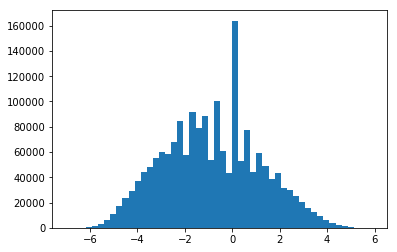

In [3]:
sim['n'] = sim['p'] + sim['d']; sim.query('n >= 10')
sim['a'] = sim['N45b'].apply(lambda x: x.count('A'))#; sim.query('a >= 12')
sim['p'] = sim['p'].apply(lambda x: 0.99 if x == 0 else x)
sim['d'] = sim['d'].apply(lambda x: 0.99 if x == 0 else x)
sim['logit'] = special.logit(sim['p']/(sim['p']+sim['d']))*-1 
sim.sort_values('n',ascending=False,inplace=True)
sim.reset_index(drop=True,inplace=True)
sim['logit'].hist(bins=50,grid=False);

In [4]:
seqs = sim['N45a']+sim['pPAS']+sim['N45b']+sim['dPAS']+sim['N45c']
# seqs = sim['N45a']+sim['N45b']+sim['N45c']
seqs = nik.one_hot_encoder(seqs)
vals = sim['logit']; del sim

In [5]:
seqs_train, seqs_test, vals_train, vals_test = nik.seq_data_splitter(seqs,vals,split=.1)

train:            1,627,149
test:               180,794


In [6]:
from sklearn import preprocessing
vals_train = preprocessing.StandardScaler().fit_transform(vals_train.values.reshape(-1,1))
vals_test = preprocessing.StandardScaler().fit_transform(vals_test.values.reshape(-1,1))

In [7]:
simple_cnn = nik.cnn_constructor(seqs_train,nf1=100,nf2=100,ks1=8,ks2=8,dense=100); simple_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 147, 100)          3300      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 147, 100)          80100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 14700)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1470100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
__________

In [8]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
simple_cnn.compile(loss='mean_squared_error', optimizer=adam)
simple_cnn.fit(seqs_train, vals_train, batch_size=100, epochs=6, verbose=1)

Epoch 1/6
1627149/1627149 [==============================] - 206s - loss: 0.3727   
Epoch 2/6
1627149/1627149 [==============================] - 219s - loss: 0.3398   
Epoch 3/6
1627149/1627149 [==============================] - 222s - loss: 0.3310   
Epoch 4/6
1627149/1627149 [==============================] - 222s - loss: 0.3263   
Epoch 5/6
1627149/1627149 [==============================] - 222s - loss: 0.3230   
Epoch 6/6
1627149/1627149 [==============================] - 222s - loss: 0.3204   


In [9]:
simple_cnn.save('simple_cnn.h5')

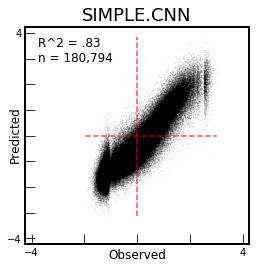

In [10]:
vals_test = vals_test.flatten()
pred = simple_cnn.predict(seqs_test).flatten()
nik.pred_scatter(vals_test,pred,title='SIMPLE.CNN',r2=True)